In [1]:
# import important modules
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory, image

# Studying the metalicity of galaxies using CNNs

Here are going to attempt to predict the [metalicity](https://en.wikipedia.org/wiki/Metallicity) of galaxies.  Metallicity (the abundance of elements heavier than helium) does a great job of summarizing a galaxy's evolutionary history, but it's not so easy to measure. Typically, astronomers measure the ratio of oxygen to hydrogen atoms in a galaxy, and spectroscopic observations are required for inferring these elemental abundances. Spectroscopy takes much more time than imaging, and is not as easy to do for many objects at once!

The physical processes that determine a galaxy's metallicity also leave imprints on the galaxy's morphology. The structure and color of a galaxy provide us with a rich description of its growth and evolution. Thus, it would make sense galaxy images might contain enough information for estimating a galaxy's metallicity.

Our goal is to explore convolutional neural networks (CNNs), so we'll use galaxy images from the [Sloan Digital Sky Survey](http://skyserver.sdss.org/dr16/en/home.aspx). These files are 3-channel 128x128 pixel images encoded in irg format (i = near infrared, r = red, g = green), where the irg formatting corresponds to the 3 image channels.  For those of you who are studying astronomy or astrophysics, you might have fun with the [image cutout service](http://skyserver.sdss.org/dr16/en/help/docs/api.aspx#imgcutout) from SDSS.  For example, this [link](http://skyserver.sdss.org/dr16/SkyserverWS/ImgCutout/getjpeg?ra=39.8486&dec=1.094&scale=1&width=224&height=224![image.png](attachment:image.png) gets you a three-channel 224x224 pixel image with RA=39.8486 and Dec = 1.094.

![An example galaxy at the coordinates RA = 39.8486 and Dec = 1.094](http://skyserver.sdss.org/dr16/SkyserverWS/ImgCutout/getjpeg?ra=39.8486&dec=1.094&scale=1&width=224&height=224!)

As you've learned, convolutional NNs are intended to be useful tools for handling grid data (ie, images!).  And the traditional use for CNNs is for image classification.  However, for this problem we will perform regression on the images to predict the metalicity of the galaxies shown in the images.  This exercise illustrates the power of the CNN to go beyond classification.

For those who are interested, this homework was inspired by [work](https://ui.adsabs.harvard.edu/abs/2019MNRAS.484.4683W/abstract) done by J. Wu and S. Boada, who were at Rutgers at the time.  They engage in some interesting interpretations of what their CNN is doing.  Yours will behave similarly.

***
***
# First, we must load the data

We need both targets and images.  It's hard to encode metalicity data into an image, so I've put the targets (ie, metalicity values) into a CSV file.  Note that this is dangerous!  If you do not keep a one-to-one match between targets and images, you will get complete garbage from your CNN.  This is solved by ordering the images in the CSV file alphanumerically, which is the order the the Keras `image_dataset_from_directory` function loads images. The images are given an object identifier that follow the filename of the images, so we can keep track.

In [2]:
# load targets (metalicity values) from stored CSV files
train_Target_csv = 'metalicity/catalogs/train.csv'
dfTrain = pd.read_csv(train_Target_csv, index_col=0)

test_Target_csv = 'metalicity/catalogs/test.csv'
dfTest = pd.read_csv(test_Target_csv, index_col=0)

# Later on, we need the Targets in list format
trainTargets = dfTrain.values[:,0].tolist()
testTargets = dfTest.values[:,0].tolist()

# descriptions
print("Description: \n", dfTrain.describe())

print("\nHead: \n",dfTrain.head())

Description: 
            oh_p50
count  400.000000
mean     8.901004
std      0.199803
min      8.133490
25%      8.824294
50%      8.950793
75%      9.047316
max      9.260791

Head: 
                 oh_p50
objID                 
1.237650e+18  8.789074
1.237650e+18  8.133490
1.237650e+18  8.882136
1.237650e+18  8.909591
1.237650e+18  9.130043


# Next, let's make a plot of metalicity

It would be good to know what we expect to find in this sample.  By plotting metalicity values, we can vidualize what our distribution of targets will be.

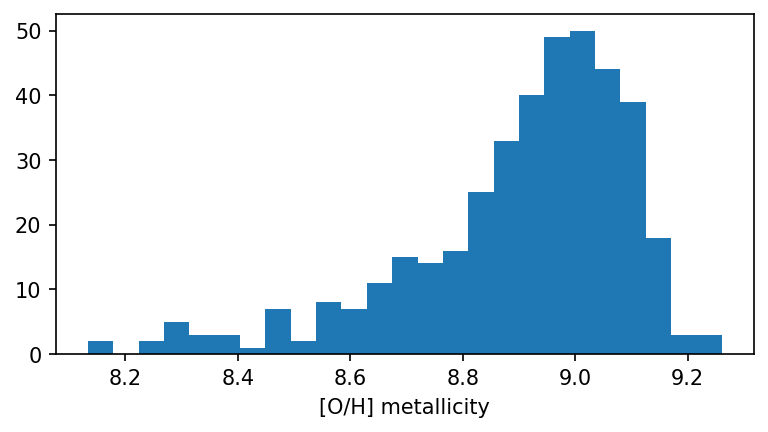

In [3]:
plt.figure(figsize=(6,3), dpi=150)
plt.hist(dfTrain.oh_p50,bins=25)
plt.xlabel('[O/H] metallicity');

# Next, we load the images

We're going to be using the `image_dataset_from_directory` from `Keras` to help organize our images and do clever things like making batches and shuffling.  You do not have to use this if you don't want to, but it's there for a reason!

In [4]:
image_size=(128, 128)
batch_size = 16

train_ds = image_dataset_from_directory(directory='metalicity/train/',
                                        labels=trainTargets,batch_size=batch_size,
                                        image_size=image_size,shuffle=False)

test_ds = image_dataset_from_directory(directory='metalicity/test/',
                                        labels=testTargets,batch_size=batch_size,
                                        image_size=image_size,shuffle=False)

Found 400 files belonging to 1 classes.
Found 100 files belonging to 1 classes.


# More plots!

Just like before, let's make some plots to see what we're dealing with.  Here we'll just do the first 9 galaxies, labeled with their metalicity targets.  Can you spot features that would help us predict metalicity?  I can't, but I'm no astrophysicist!

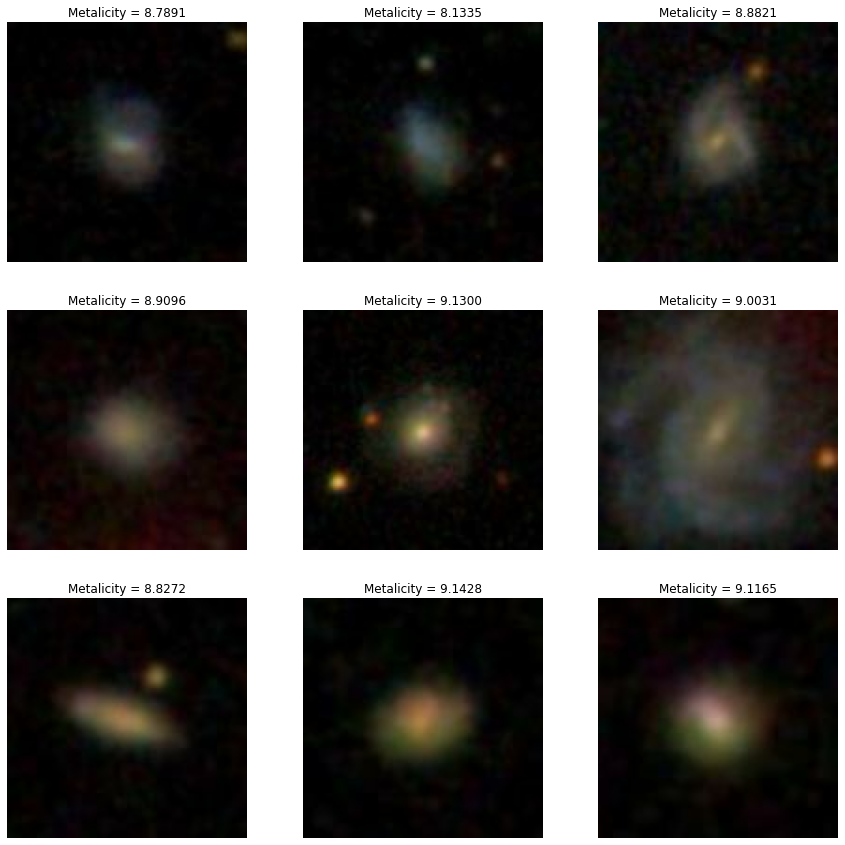

In [5]:
plt.figure(figsize=(15, 15))
    
for images, targets in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Metalicity = {targets[i]:.4f}")
        plt.axis("off")

# Augmented data!!

Keras has a very cool feature that allows you to manipulate your images in ways that you expect should _NOT_ impact the classification or regression results.  In this case we're going to create a data augmentation tool that is itself a "NN" model with two layers.  The first layer is going to do a random horizontal flip of the image.  And the 2nd layer will do a random rotation.

The way we'll use this is to add our augmentation tool to our model and thereby randomly vary our input data on every training cycle.  This is an excellent way to avoid overtraining, as the training data looks a bit different on each training epoch.

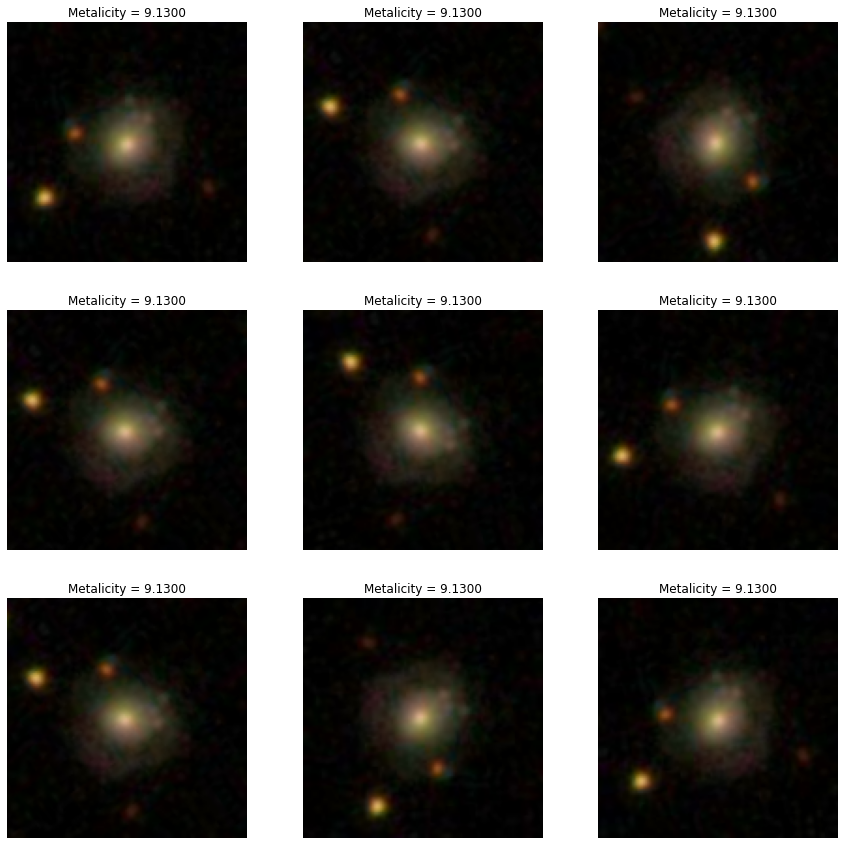

In [6]:
# create a Keras NN model and add layers
data_augmentation = keras.Sequential(
    [
        # This layer will do random horizontal flips of our images
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        
        # This layer will do random rotations of size 0.25*2*Pi
        layers.experimental.preprocessing.RandomRotation(0.25),
    ]
)

plt.figure(figsize=(15, 15))
for images, targets in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[4].numpy().astype("uint8"))
        plt.title(f"Metalicity = {targets[4]:.4f}")
        plt.axis("off")

***
# Next let's build a Convolutional Neural Network using Keras

I have set this process up in two steps so that you can get a good feeling for the network architecture before training it.  Use the existing print statements (and add your own!) to gain insight into what architecture variants achieve and what your receptive field might be for a given layer.  Note that I stopped at 3 layers, but that should not influence your choices.  I'm just lazy.

1. `buildModel()` builds your Keras CNN:  Feel free to change the activation, but elu and relu are good choices if you want to avoid that exploration step.
2. `trainModel()` trains your CNN: This is a regression problem, so mean squared error is a great choice of loss function.  And the Adam SGD optimizer is a generically good choice.  Again, feel free to change these but you shouldn't feel obliged to do so for this problem.

If you get crazy about making a deep network, you'll spend more time training to get a good model.  Please keep that in mind.  The "default" here is two layers with 16 and 32 filters, respectively.  This trains over 50 epochs in <5 minutes on my Macbook and yields MSE<0.1 and mean_absolute_percentage_error < 2\%.  So you should not expect to need to use a 4-layer CNN with hundreds of filters!



In [7]:
def buildModel(input_shape, final_size, l1_filters, l2_filters, k_size=5, l3_filters=0):
    
    # elu is a good choice, but relu would do well also
    activate = "elu"

    # create your input layer
    inputs = keras.Input(shape=input_shape)

    # perform data augmentation
    x = data_augmentation(inputs)
    
    # our inputs span the space of [0,255] for the encoding in 8 bits
    # we need to process the inputs to [0,1] to make the CNNs job easier
    x = layers.experimental.preprocessing.Rescaling(1./255)(x)
    print("Input shape: \t",x.shape)
    
    # optionally consider reducing the image resolution
    # this can speed up your CNN, at the cost of...resolution
    x = layers.experimental.preprocessing.Resizing(final_size,final_size)(x)
    print("Resize shape: \t",x.shape)
    
    # These four layers together form one "unit" of your CNN
    # 1- Convolutional layer.  It's typically good to have a small kernel size for the first CNN layer.
    # 2- Batch normalization layer.  Center your features and normalize width.
    # 3- Activation layer: Add a nonlinearity!
    # 4- Pooling layer: I used max pooling.  Is that the best choice?
    x = layers.Conv2D(filters=l1_filters, kernel_size=3)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activate)(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    print("Post Layer 1 shape: \t",x.shape)
    
    # Second CNN unit
    # Note that the pooling layer is only included if
    # we have another CNN unit coming next.  Why is that?
    x = layers.Conv2D(filters=l2_filters, kernel_size=k_size)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activate)(x)
    print("Post Layer 2 shape: \t",x.shape)

    if l3_filters > 1:
        # If requested, add a 3rd CNN unit...but complete
        # the previous unit by adding a pooling layer first.
        x = layers.MaxPooling2D(pool_size=2)(x)
        x = layers.Conv2D(filters=l3_filters, kernel_size=k_size)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation(activate)(x)
        print("Post Layer 3 shape: \t",x.shape)

    # Final pooling layer.  This is important!
    # What is it doing?
    x = layers.GlobalMaxPooling2D()(x)
    print("Post Pool shape: \t",x.shape)

    # Finally, we'll make a fully-connected layer with no
    # activation function.  We'll just sum up the outputs
    # Alternatively, you could add activation = 'sigmoid' or
    # similar.  Would that help??
    outputs = layers.Dense(units=1)(x)

    # Now that we have outputs and inputs
    # let's build the model
    model = keras.Model(inputs, outputs) 
    print("Output shape: \t", model.output_shape)

    return model

def trainModel(model, dset, epochs=50, verbose=True, lr=3e-4):
    # We need to compile our model, wherein we define:
    # - The loss function
    # - The SGD optimizer
    # - Any metrics we want the model to track
    print("Training with LR = ",lr)

    # Adam is always a good choice for the optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    # MSE is a great loss choice and it's fun to also know the
    # absolute percentage error.
    model.compile(loss="MeanSquaredError",optimizer=optimizer,
                  metrics=['MeanAbsolutePercentageError'] )
    
    # Finally, we'll fit our model and then deploy it
    model.fit(dset,
              workers=2,use_multiprocessing=True,
              verbose=verbose,epochs =epochs)
    
    return model

In [8]:
# Make a model.  Make as many as you like, in fact.
# Note that we need to tell the model that the input shape is (128,128,3)
# The final_size variable is useful for reducing the granularity of the image.
# If you reduce final_size from 128, just make sure that you understand what
# the rest of your model will do with that choice.  For example, if you have
# a 32x32 model and 3 pooling(2) layers you will go from 32->16->8->4 over 
# those layers.  A kernel size larger than 4 will not work in the last layer.

aModel = buildModel(input_shape=image_size+(3,), final_size=128, l1_filters=16, l2_filters=32)

Input shape: 	 (None, 128, 128, 3)
Resize shape: 	 (None, 128, 128, 3)
Post Layer 1 shape: 	 (None, 63, 63, 16)
Post Layer 2 shape: 	 (None, 59, 59, 32)
Post Pool shape: 	 (None, 32)
Output shape: 	 (None, 1)


In [15]:
# Train your model!
# What you see here is a staged training cycle in which
# the learning rate is increased iteratively.  This is
# an easy way to speed up training without a fancy 
# algorithm to do the work for you.

trainModel(aModel, train_ds, epochs = 3, lr=0.1) # A few big steps to get us in the general neighborhood
trainModel(aModel, train_ds, epochs = 10, lr=0.01) # Smaller, yet still big, steps
trainModel(aModel, train_ds, epochs = 12, lr=0.001) # The Adam default is 1e-3
trainModel(aModel, train_ds, epochs = 12, lr=0.0005) # Now that we're close, let's refine
trainModel(aModel, train_ds, epochs = 8, lr=0.0001) # Even more refinement
trainModel(aModel, train_ds, epochs = 5,lr=0.00005) # final nail in the coffin

Training with LR =  0.1
Epoch 1/3
25/25 [==============================] - 4s 155ms/step - loss: 9.9733 - mean_absolute_percentage_error: 25.6996
Epoch 2/3
25/25 [==============================] - 4s 155ms/step - loss: 0.5260 - mean_absolute_percentage_error: 6.5218
Epoch 3/3
25/25 [==============================] - 4s 153ms/step - loss: 0.2809 - mean_absolute_percentage_error: 4.9558
Training with LR =  0.01
Epoch 1/10
25/25 [==============================] - 4s 152ms/step - loss: 0.1676 - mean_absolute_percentage_error: 3.5672
Epoch 2/10
25/25 [==============================] - 4s 143ms/step - loss: 0.2364 - mean_absolute_percentage_error: 4.2538
Epoch 3/10
25/25 [==============================] - 4s 146ms/step - loss: 0.1229 - mean_absolute_percentage_error: 2.9710
Epoch 4/10
25/25 [==============================] - 4s 147ms/step - loss: 0.1361 - mean_absolute_percentage_error: 3.1395
Epoch 5/10
25/25 [==============================] - 4s 152ms/step - loss: 0.1264 - mean_absolute_pe

In [16]:
# Make predictions for your model.  Get both test and train!
predictionsTrain = aModel.predict(train_ds)

predictionsTest = aModel.predict(test_ds)
print("One prediction and its true value: ",predictionsTrain[0], trainTargets[0])

One prediction and its true value:  [8.703137] 8.789074


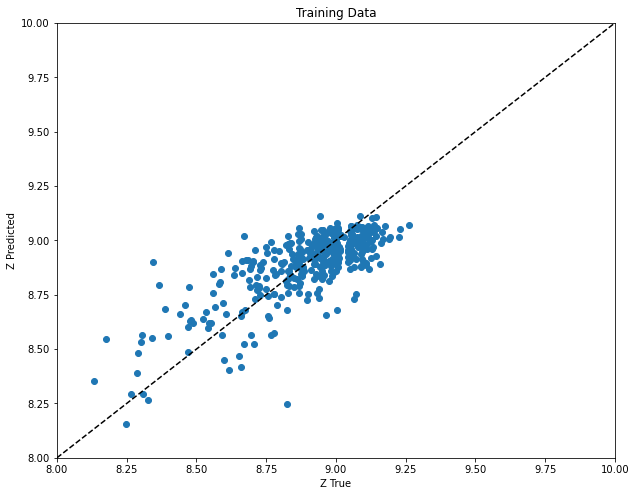

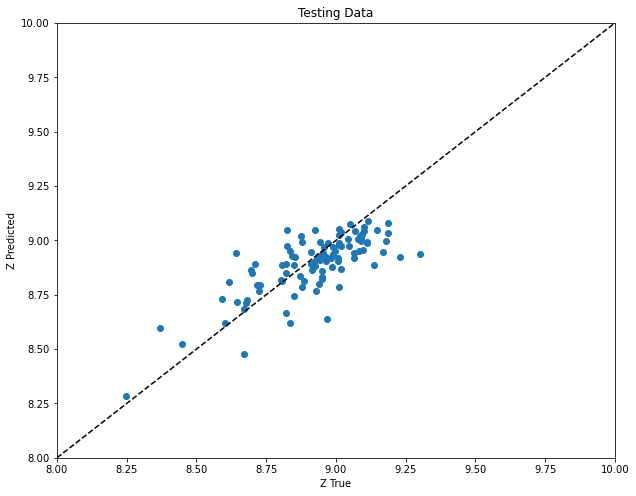

In [17]:
# Make some plots to see how we did!
fig = plt.figure(figsize=(10,8))
plt.scatter(trainTargets,predictionsTrain)
plt.xlim(8, 10)
plt.ylim(8, 10)
plt.ylabel("Z Predicted")
plt.xlabel("Z True")
plt.title("Training Data")
plt.plot(plt.xlim(), plt.ylim(), ls='--', c='k');
plt.show()

fig = plt.figure(figsize=(10,8))
plt.scatter(testTargets,predictionsTest)
plt.xlim(8, 10)
plt.ylim(8, 10)
plt.ylabel("Z Predicted")
plt.xlabel("Z True")
plt.title("Testing Data")
plt.plot(plt.xlim(), plt.ylim(), ls='--', c='k');
plt.show()

Training mean/rms:  0.9992122 0.014574545


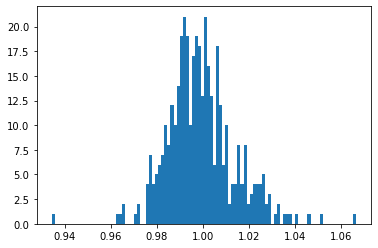

Testing mean/rms:  0.9969145 0.013327405


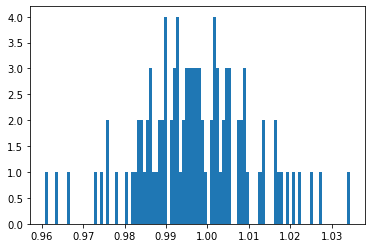

In [18]:
# 2D plots are great, but how well did we really do?
# Let's use the mean and RMS of the predictions to the labels
# to judge our CNNs accuracy.  We want a mean near 1.0 and
# an RMS as small as possible.  Best to judge by the testing 
# data set in case of overtraining!
ratioTrain = np.copy(predictionsTrain)
for idx, target in  enumerate(trainTargets):
    ratioTrain[idx] /= target
print("Training mean/rms: ",ratioTrain.mean(), ratioTrain.std())
plt.hist(ratioTrain,bins=100)
plt.show()

ratioTest = np.copy(predictionsTest)
for idx, target in  enumerate(testTargets):
    ratioTest[idx] /= target
print("Testing mean/rms: ",ratioTest.mean(), ratioTest.std())
plt.hist(ratioTest,bins=100)
plt.show()